Data Link: https://drive.google.com/file/d/18iTYm3fDtlOICW4Jj9A8j7JPJX_AVpkX/view?usp=sharing

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os


In [6]:
!unzip /content/Flowers_Classification_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Flowers_Classification_dataset/train/daisy/4613992315_143ccc2a10_m_jpg.rf.b73ea2c4ff54694fa5400385c68f8c31.jpg  
  inflating: Flowers_Classification_dataset/train/daisy/4613992315_143ccc2a10_m_jpg.rf.c97783768121e29070fd6dad98707437.jpg  
  inflating: Flowers_Classification_dataset/train/daisy/4654579740_6671a53627_m_jpg.rf.1778ca1c7044256b0e21f0109fa78621.jpg  
  inflating: Flowers_Classification_dataset/train/daisy/4654579740_6671a53627_m_jpg.rf.6332dd39a680e80f7489bea5f991c9ce.jpg  
  inflating: Flowers_Classification_dataset/train/daisy/4654579740_6671a53627_m_jpg.rf.840413b8f71912e8b467aab8060599c8.jpg  
  inflating: Flowers_Classification_dataset/train/daisy/4654579740_6671a53627_m_jpg.rf.85731e739e4083853ad0a3bd2ba2708a.jpg  
  inflating: Flowers_Classification_dataset/train/daisy/4654579740_6671a53627_m_jpg.rf.b2d1a29a941b34de666e45c866c0e322.jpg  
  inflating: Flowers_Classification_dataset/train/daisy/4657354814_

In [15]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            # These values are used because many pretrained models (like ResNet, VGG)
            # were trained on ImageNet with this exact normalization.
            [0.485, 0.456, 0.406],   # mean for R, G, B
            [0.229, 0.224, 0.225])   # std  for R, G, B
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [10]:
# Define the data directory
data_dir = '/content/Flowers_Classification_dataset'

# Create datasets for training and validation
image_datasets = {
    x: datasets.ImageFolder(          # Load images from folders
        os.path.join(data_dir, x),    # Path: data_dir/train or data_dir/valid
        data_transforms[x]            # Apply the right transform (train/valid)
    )
    for x in ['train', 'val']       # Do it for both train and valid sets
}


In [11]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6375
     Root location: /content/Flowers_Classification_dataset/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 364
     Root location: /content/Flowers_Classification_dataset/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [26]:
# Create dataloaders for training and validation
dataloaders = {
    x: torch.utils.data.DataLoader(   # Wrap datasets into DataLoader
        image_datasets[x],            # Use training or validation dataset
        batch_size=4,                 # Load 4 images at a time
        shuffle=True,                 # Shuffle data each epoch
        num_workers=4                 # Use 4 subprocesses (threads) for faster loading
    )
    for x in ['train', 'val']         # Do it for both train and val
}

# Store dataset sizes (number of images in train and val)
dataset_sizes = {
    x: len(image_datasets[x])         # Count images for each dataset
    for x in ['train', 'val']
}
print(dataset_sizes)                  # Example output: {'train': 2000, 'val': 500}


{'train': 6375, 'val': 364}


In [28]:
# Get the class names from training dataset (folder names = labels)
class_names = image_datasets['train'].classes
class_names                             # Example: ['daisy', 'dadelion']

['daisy', 'dandelion']

In [13]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()   # Tells the model “how wrong” its predictions are so it can adjust weights.
optimizer = optim.SGD(              # Uses the gradients (from loss.backward()) to update model weights step by step.
    model.parameters(),             # Controls how big each weight update is (Neither too high, nor too low)
    lr=0.001, momentum=0.9)         # Think of it like adding inertia, makes learning faster and more stable.


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


In [16]:
# Training loop

# Train for 2 epochs (go through the whole dataset 2 times)
num_epochs = 2
for epoch in range(num_epochs):
    # Two phases: training and validation
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        # Track results for this epoch
        running_loss = 0.0
        running_corrects = 0

        # Loop through all mini-batches in the chosen phase
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)  # Move images to GPU/CPU
            labels = labels.to(device)

            optimizer.zero_grad() # Reset previous gradients

            # Only calculate gradients in training phase
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)           # Forward pass
                _, preds = torch.max(outputs, 1)  # Predicted class index
                loss = criterion(outputs, labels) # Compare prediction vs truth

                if phase == 'train':
                    loss.backward()   # Backpropagation
                    optimizer.step()  # Update weights

            # Update tracking variables
            running_loss += loss.item() * inputs.size(0)   # Total loss
            running_corrects += torch.sum(preds == labels.data)  # Correct preds

        # Compute average loss and accuracy for this phase
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Model trained successfully.")


train Loss: 0.5140 Acc: 0.7906
val Loss: 0.1639 Acc: 0.9286
train Loss: 0.5425 Acc: 0.7834
val Loss: 0.1774 Acc: 0.9341
Model trained successfully.


In [17]:

# Save the model
torch.save(model.state_dict(), 'trained_model.pth')


# Classification on Unseen Image

To use the saved model to classify unseen images, you need to load the model and then apply it to the new images for inference.

In [19]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]




Prepare your new image for classification. You should use the same data transformations you used during training. Here's an example of how to prepare an image for inference:

In [21]:
# Load and preprocess the unseen image
image_path = 'test.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension


Perform inference using the model:

In [22]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['daisy', 'dandelion']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')


The predicted class is: daisy


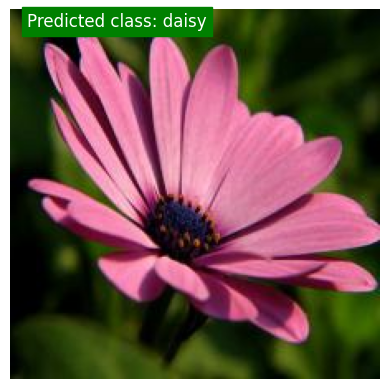

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted class: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='green')
plt.show()